# Foundations of AI & ML
## Session 10
### Experiment 4
#### RNNs for financial forecasting

In this experiment, we will be using stock market dataset. The dataset contains historical daily price and volume data for all US-based stocks and E
TFs trading on the NYSE, NASDAQ, and NYSE MKT.

#### Importing Packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
### importing pytorch packages
import torch
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader

#### Loading the directory

In [2]:
import os
##Loading the data folder
print(os.listdir("../Datasets/Data"))

['ETFs', 'Stocks']


#### Creating a model to load the stock data

In [3]:
class StockDataset(Dataset):

    def __init__(self, x_data_to_process, y_data_to_process):
        """ inputs for x and y values are given as pandas obj """
        self.data = pd.merge(x_data_to_process, y_data_to_process, on='Date')
        self.data = self.data.values    # from pd to np

        print('The shape of the data is {}'.format(self.data.shape))

        self.x_data = self.data[:, 1:x_data_to_process.shape[1]].astype(np.float32)
        self.y_data = self.data[:, x_data_to_process.shape[1]:].astype(np.float32)

        """ Normalize x_data, putting it off for now """
        self.rebase_to_one()

        """ convert to torch """
        self.x_data = torch.from_numpy(self.x_data)
        self.y_data = torch.from_numpy(self.y_data)

        self.len = self.data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

    def rebase_to_one(self):
        """ self.x_data rebased to one on the firsts element """
        self.x_data = self.x_data.T
        list_of_first_elem_price = [i[0] for i in self.x_data]
        shape_row, shape_column = self.x_data.shape[0], self.x_data.shape[1]

        for i in range(shape_row):
            for j in range(shape_column):
                self.x_data[i][j] /= list_of_first_elem_price[i]
        self.x_data = self.x_data.T


# We load the stock data from the dataset folder.
def get_dictionary_of_data():
    def get_dictionary_of_data_helper(list_of_stocks):
        dict_of_stocks = {}
        for i in range(len(list_of_stocks)):
            key = str(list_of_stocks[i]).lower()
            path ='../Datasets/Data/Stocks/{}.us.txt'.format(key)
            try:
                dict_of_stocks[key] = pd.read_csv(path)
            except IOError:
                print("File of {} not found".format(key))

        return dict_of_stocks

    # Use these tickers if possible to predict S&P's value
    spx_partial_list = np.array(['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO',
                                     'KO', 'DWDP', 'XOM', 'GE', 'GS', 'HD', 'IBM', 'INTC',
                                     'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG',
                                     'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'DIS'])

    return get_dictionary_of_data_helper(spx_partial_list)

### we are collecting closing price data 
def closing_prices_in_pd(dict_of_stocks):
    """ merge stock data on Dates """
    temp_dict = {}
    for i in dict_of_stocks.keys():
        temp_dict[i] = (dict_of_stocks[i])[['Date', 'Close', 'Volume']]

    merged = None
    for i in temp_dict.keys():
        if merged is None:
            merged = temp_dict[i]
        elif temp_dict[i].shape[0] > 3000: # Arbitrary selection, longer than 3000
            merged = pd.merge(merged, temp_dict[i], on='Date')

    return merged

#### Let us build a rnn model

In [4]:
class Model(torch.nn.Module):

    def __init__(self, input_size, rnn_hidden_size, output_size):

        super(Model, self).__init__()

        self.rnn = torch.nn.RNN(1, rnn_hidden_size,
                                num_layers=2, nonlinearity='relu',
                                batch_first=True)
        self.h_0 = self.initialize_hidden(rnn_hidden_size)

        self.linear = torch.nn.Linear(rnn_hidden_size, output_size)
    ### Forward Pass
    def forward(self, x):
        self.rnn.flatten_parameters()
        #print(x.size())
        x, _ = self.rnn(x)
        x = x[:,:,-1]
        #print(x.size())
        out = self.linear(x)
        #print(out.size())
        return out

    def initialize_hidden(self, rnn_hidden_size):
        # n_layers * n_directions, batch_size, rnn_hidden_size
        return Variable(torch.randn(2, 1, rnn_hidden_size),
                        requires_grad=True)

#### Defining a train function

In [5]:
RNN_HIDDEN_SIZE = 24


def train(input_size, hidden_size, output_size, train_loader):
    plt.figure(1, figsize=(12, 5))

    file_path = 'my_model.model'

    try:
        model = torch.load(file_path)
    except:
        model = Model(input_size, hidden_size, output_size)
    ## Defining loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 25

    for epoch in range(epochs):
        predictions = []
        correct_values = []

        for i, data in enumerate(train_loader):
            xs, ys = data
            
            ## Converting xs,ys into tourch variables
            xs, ys = Variable(xs), Variable(ys)
            #print(xs.shape)
            xs = torch.unsqueeze(xs,2)
            #print(xs.shape)
            ## predicting the values
            y_pred = model(xs)
            ## Calculating the loss
            loss = criterion(y_pred, ys)
            optimizer.zero_grad()
            ## Backward Pass
            loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()
            ### Storing the predicted values into list in form of numpy array
            predictions.append(y_pred.cpu().data.numpy().ravel())
            correct_values.append(ys.cpu().data.numpy().ravel())
            
        def stacking_for_charting(given_list):
            ret = np.array([0])
            for i in given_list:
                ret = np.hstack((ret, i.ravel()))
            return ret[1:]
        ## Stacking the predictions values
        predictions_for_chart = stacking_for_charting(predictions)
        correct_values_for_chart = stacking_for_charting(correct_values)

        print(predictions_for_chart)

        steps = np.linspace(epoch*predictions_for_chart.shape[0],
                            (epoch+1)*predictions_for_chart.shape[0],
                            predictions_for_chart.shape[0])
        ## plotting the predicted values
        plt.plot(steps, predictions_for_chart, 'r-')
        ##plotting the original values
        plt.plot(steps, correct_values_for_chart, 'b-')
        plt.draw()
        plt.pause(0.05)

    torch.save(model, file_path)
    plt.show()

#### Function to load the dataset

In [ ]:
def main():

    """ getting dictionary of stock data ETFs"""
    X_data_source = get_dictionary_of_data()

    """ etf data is used as Y variable"""
    Y_data_source = {'spy': pd.read_csv('../Datasets/Data/ETFs/spy.us.txt')}

    X_data = closing_prices_in_pd(X_data_source)
    Y_data = closing_prices_in_pd(Y_data_source)
    
    #print(X_data.shape,Y_data.shape)

    Y_data = Y_data.drop(['Volume'], axis=1)

    dataset = StockDataset(X_data, Y_data)
    ## Loading the dataset
    train_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=False, num_workers=1)

    input_size = X_data.shape[1]-1
    hidden_size = RNN_HIDDEN_SIZE
    output_size = Y_data.shape[1]-1
    ## training the model
    train(input_size, hidden_size, output_size, train_loader)

File of mmm not found
File of axp not found
File of cat not found
File of ko not found
File of ge not found
File of gs not found
File of hd not found
File of ibm not found
File of intc not found
File of jnj not found
File of mrk not found
File of pg not found
File of trv not found
File of unh not found
File of utx not found
File of v not found
File of wmt not found
File of dis not found
The shape of the data is (3200, 26)
[-0.25352398 -0.25349954 -0.25543863 ... -0.06923366 -0.06923366
 -0.06923366]


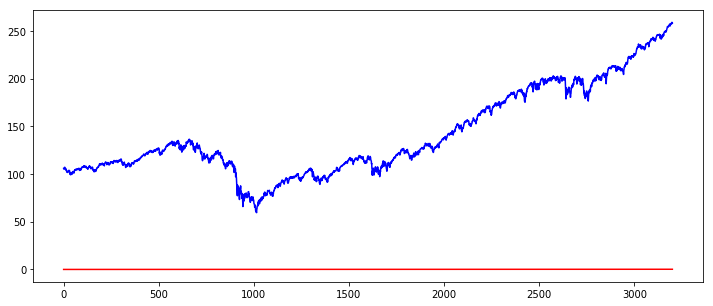

[-0.06821296 -0.06821296 -0.06821296 ...  0.03216293  0.03216293
  0.03216293]


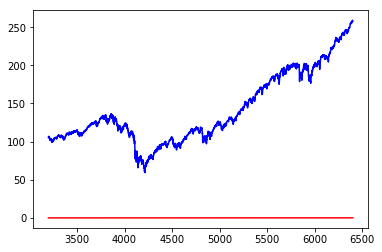

[0.03317261 0.03317261 0.03317261 ... 0.1329288  0.1329288  0.1329288 ]


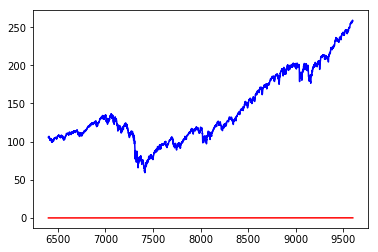

[0.1339349  0.1339349  0.1339349  ... 0.23344192 0.23344192 0.23344192]


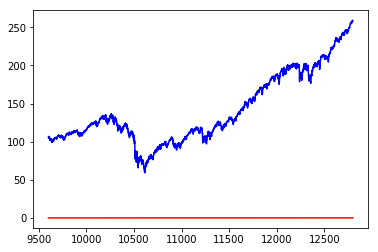

[0.23444624 0.23444624 0.23444624 ... 0.33381832 0.33381832 0.33381832]


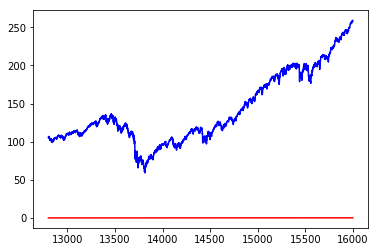

[0.33482158 0.33482158 0.33482158 ... 0.43410918 0.43410918 0.43410918]


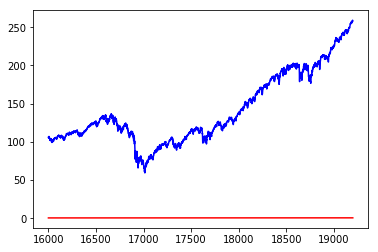

[0.43511176 0.43511176 0.43511176 ... 0.53434187 0.53434187 0.53434187]


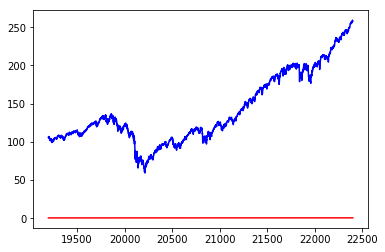

[0.53534395 0.53534395 0.53534395 ... 0.63453227 0.63453227 0.63453227]


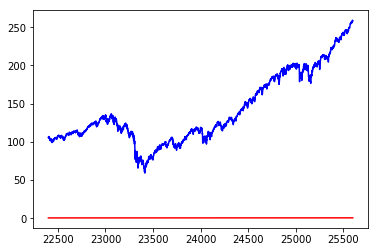

[0.63553399 0.63553399 0.63553399 ... 0.73469102 0.73469102 0.73469102]


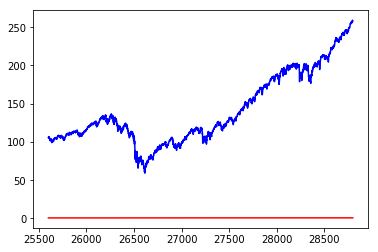

In [ ]:
main()